In [1]:
import os
import pandas as pd
import seaborn as sns

In [2]:
import models.logic_inference as logic_inference

In [2]:
'\n------'.split(" ")

['\n------']

In [3]:
[item for sublist in [[1,0],[4,5]] for item in sublist]

[1, 0, 4, 5]

In [4]:
from transformers import AutoTokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

In [34]:
29871 in tokenizer.encode("Predicates:\nCold(x) ::: x is cold\nQuiet(x) ::: x is quiet\nRed(x) ::: x is red\nSmart(x) ::: x is smart\nKind(x) ::: x is kind\nRough(x) ::: x is rough\nPremises:\nCold(bob) ∧ Quiet(bob) ∧ Red(bob) ∧ Smart(bob)\nKind(charlie) ∧ Quiet(charlie) ∧ Red(charlie) ∧ Rough(charlie)\nCold(dave) ∧ Kind(dave) ∧ Smart(dave)\nQuiet(fiona)\n∀x ((Quiet(x) ∧ Cold(x)) → Smart(x))\nRed(x) ∧ Cold(x) → Round(x)\n∀x ((Kind(x) ∧ Rough(x)) → Red(x))\n∀x (Quiet(x) → Rough(x))\n∀x (Cold(x) ∧ Smart(x) → Red(x))\n∀x (Rough(x) → Cold(x))\n∀x (Red(x) → Rough(x))\n∀x ((Smart(x) ∧ Kind(x)) → Quiet(x))\nConclusion:\nKind(charlie) ::: Charlie is kind.\n------", add_special_tokens=False)

True

In [35]:
res=tokenizer.encode("Predicates:\nCold(x) ::: x is cold\nQuiet(x) ::: x is quiet\nRed(x) ::: x is red\nSmart(x) ::: x is smart\nKind(x) ::: x is kind\nRough(x) ::: x is rough\nPremises:\nCold(bob) ∧ Quiet(bob) ∧ Red(bob) ∧ Smart(bob)\nKind(charlie) ∧ Quiet(charlie) ∧ Red(charlie) ∧ Rough(charlie)\nCold(dave) ∧ Kind(dave) ∧ Smart(dave)\nQuiet(fiona)\n∀x ((Quiet(x) ∧ Cold(x)) → Smart(x))\nRed(x) ∧ Cold(x) → Round(x)\n∀x ((Kind(x) ∧ Rough(x)) → Red(x))\n∀x (Quiet(x) → Rough(x))\n∀x (Cold(x) ∧ Smart(x) → Red(x))\n∀x (Rough(x) → Cold(x))\n∀x (Red(x) → Rough(x))\n∀x ((Smart(x) ∧ Kind(x)) → Quiet(x))\nConclusion:\nKind(charlie) ::: Charlie is kind.\n------", add_special_tokens=False)

In [49]:
len(res)

325

In [40]:
res.index(29871)

81

In [38]:
29871 in res

True

In [43]:
tokenizer.decode(res[80:89])

') ∧ Quiet(bob)'

In [47]:
import numpy as np

In [48]:
np.log(-float('inf'))

/tmp/ipykernel_133442/332207705.py:1: RuntimeWarning: invalid value encountered in log
  np.log(-float('inf'))


nan

In [29]:
tokenizer.decode([29871, 13, 22158])

'\n------'

In [30]:
tokenizer.decode([29871])

''

In [1]:
[0,1][-4:]

[0, 1]

In [3]:
import argparse

In [4]:
import re
import json
import os
import argparse

def get_choice(answer_str):
    choices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'A)', 'B)', 'C)', 'D)', 'E)', 'F)', 'G)', 'H)', 
               'A.', 'B.', 'C.', 'D.', 'E.', 'F.', 'G.', 'H.']
    
    if answer_str is None:
        return ''
    answer_str=answer_str.strip()
    
    for c in choices:
        if answer_str.startswith(c):
            return c.replace(')', '')

    if answer_str.startswith(':'):
       return answer_str.replace(':', '').replace('.', '').strip()
    return ''

def evaluate_QA(QA_results):
    total_em = 0.0
    not_in_options = 0.0
    count = 0
    for sample in QA_results:
        gold_answer = sample['answer'].replace('(', '').replace(')', '').strip()
        answer_str = sample['predicted_answer'].strip() if sample['predicted_answer'] is not None else ''
        prediction = get_choice(answer_str)

        indicators = ['the correct option is', 'the correct answer is', 
                      'The correct answer is', 'The correct option is',
                      'Thus, the answer is']
        if prediction is None:
            for indicator in indicators:
                if answer_str.find(indicator)>=0:
                    answer_str = answer_str.split(indicator)[1].strip()
                    prediction = get_choice(answer_str)
                    break

        if prediction is None:
            not_in_options+=1
            
        em_score = 1.0 if prediction == gold_answer else 0.0
        total_em += em_score
        count += 1
    
    if count!=0:
        avg_em = total_em / count
    else:
        avg_em = 0
    return avg_em

def full_evaluation(result_file):
    with open(result_file, 'r') as f:
        all_samples = json.load(f)

    executable_samples = [sample for sample in all_samples if sample['flag'] == 'success']
    return evaluate_QA(all_samples), len(executable_samples)/len(all_samples), evaluate_QA(executable_samples)

In [5]:
df_main = pd.DataFrame(columns=["model","iteration","split","iteration","exec_rate","exec_accuracy","accuracy"])

# Direct and CoT results

In [6]:
df_all=[]
for file in os.listdir("./outputs/results"):
    if "mini_test" in file:
        continue

    if "Bloke" in file:
        continue

    if "checkpoint" in file:
        continue
    
    mode, dataset, split, model = file.split("_")
    model = model[:-5]
    result_file = os.path.join("./outputs/results",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    df["clean_answer"] = df.predicted_answer.apply(get_choice)
    df = df.drop(columns=["question","predicted_reasoning", "predicted_answer"])
    df["answer"] = df.answer.str.replace('(', '').replace(')', '')
    df["is_correct"] = df.answer == df.clean_answer
    df["is_empty"] = df.clean_answer == ''
    df["mode"] = mode
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model
    df["refiment"] = 0
    df_all.append(df)

In [7]:
df_all2=pd.concat(df_all)
df_all3=df_all2.groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

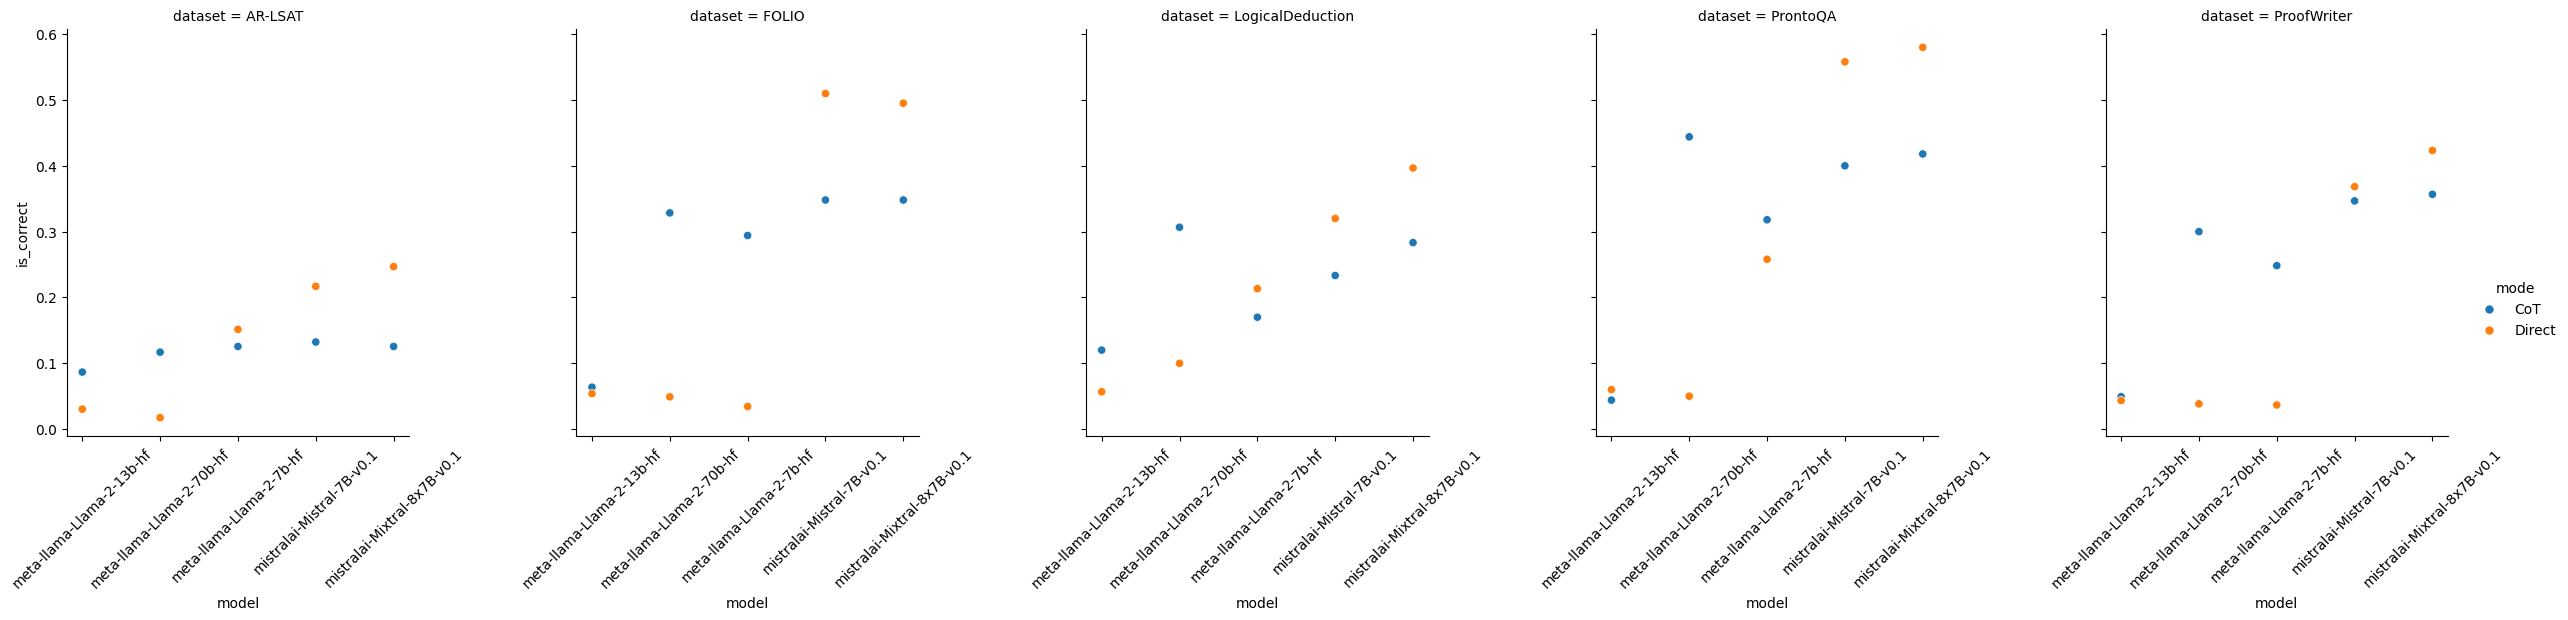

In [8]:
sns.relplot(data=df_all3,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

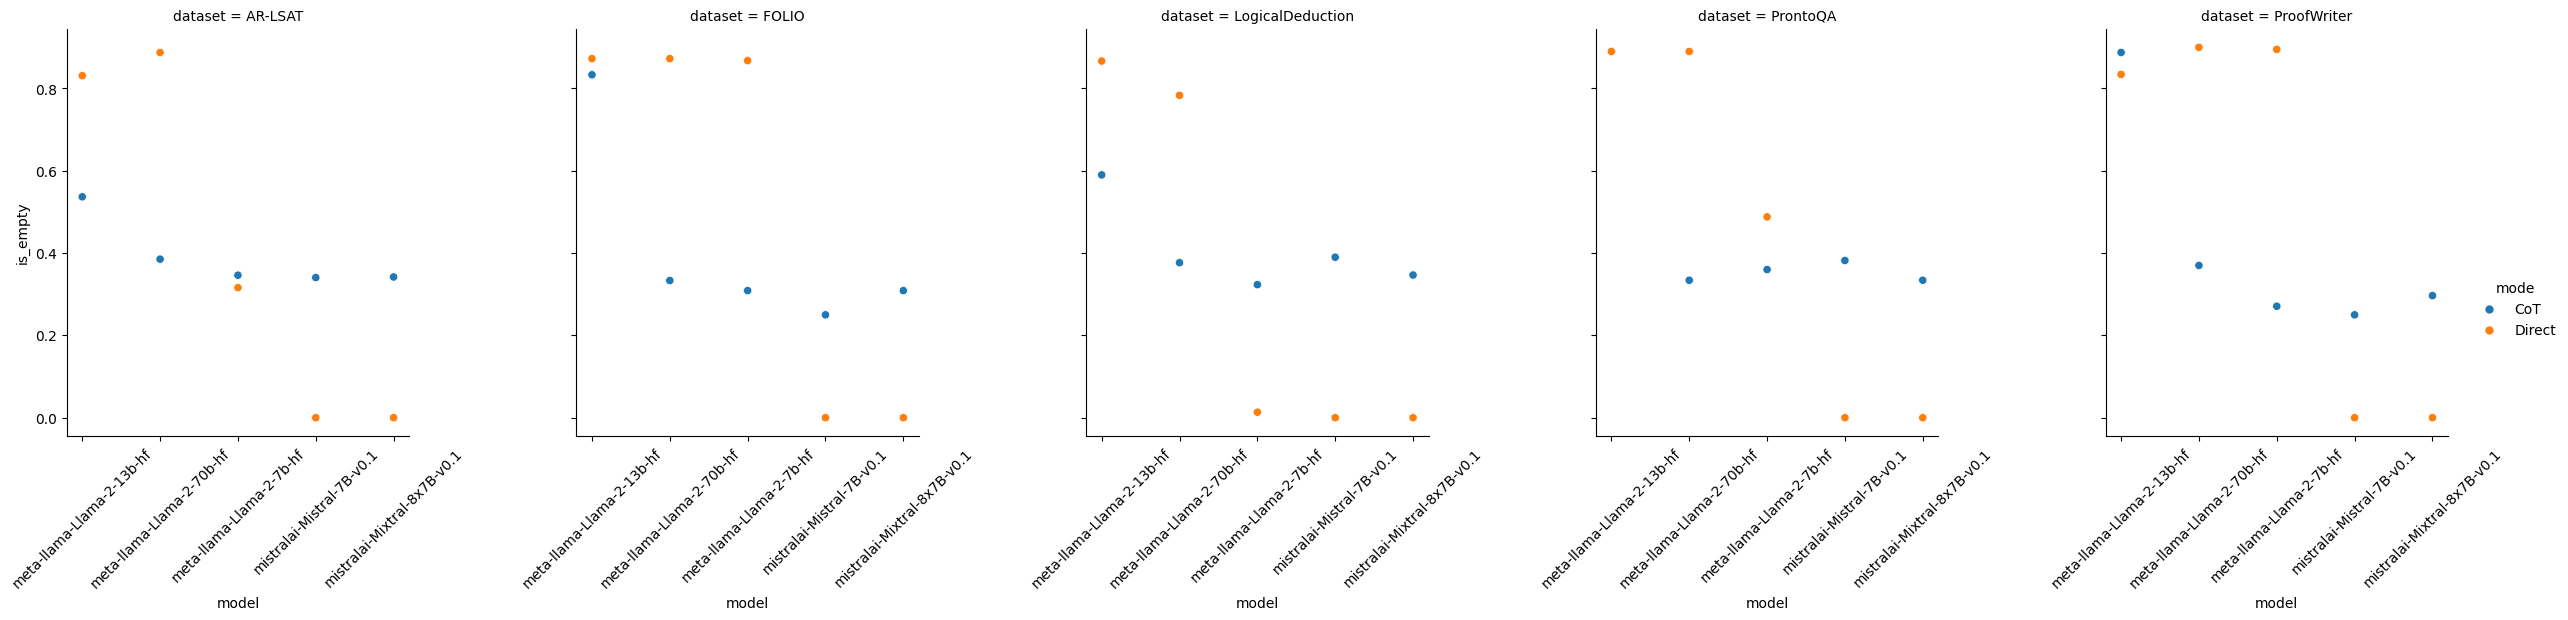

In [9]:
sns.relplot(data=df_all3,x="model",y="is_empty",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [10]:
df_all4=df_all2.loc[df_all2.is_empty!=True,:].groupby(["model","dataset","mode"])[["is_correct","is_empty"]].mean().reset_index()

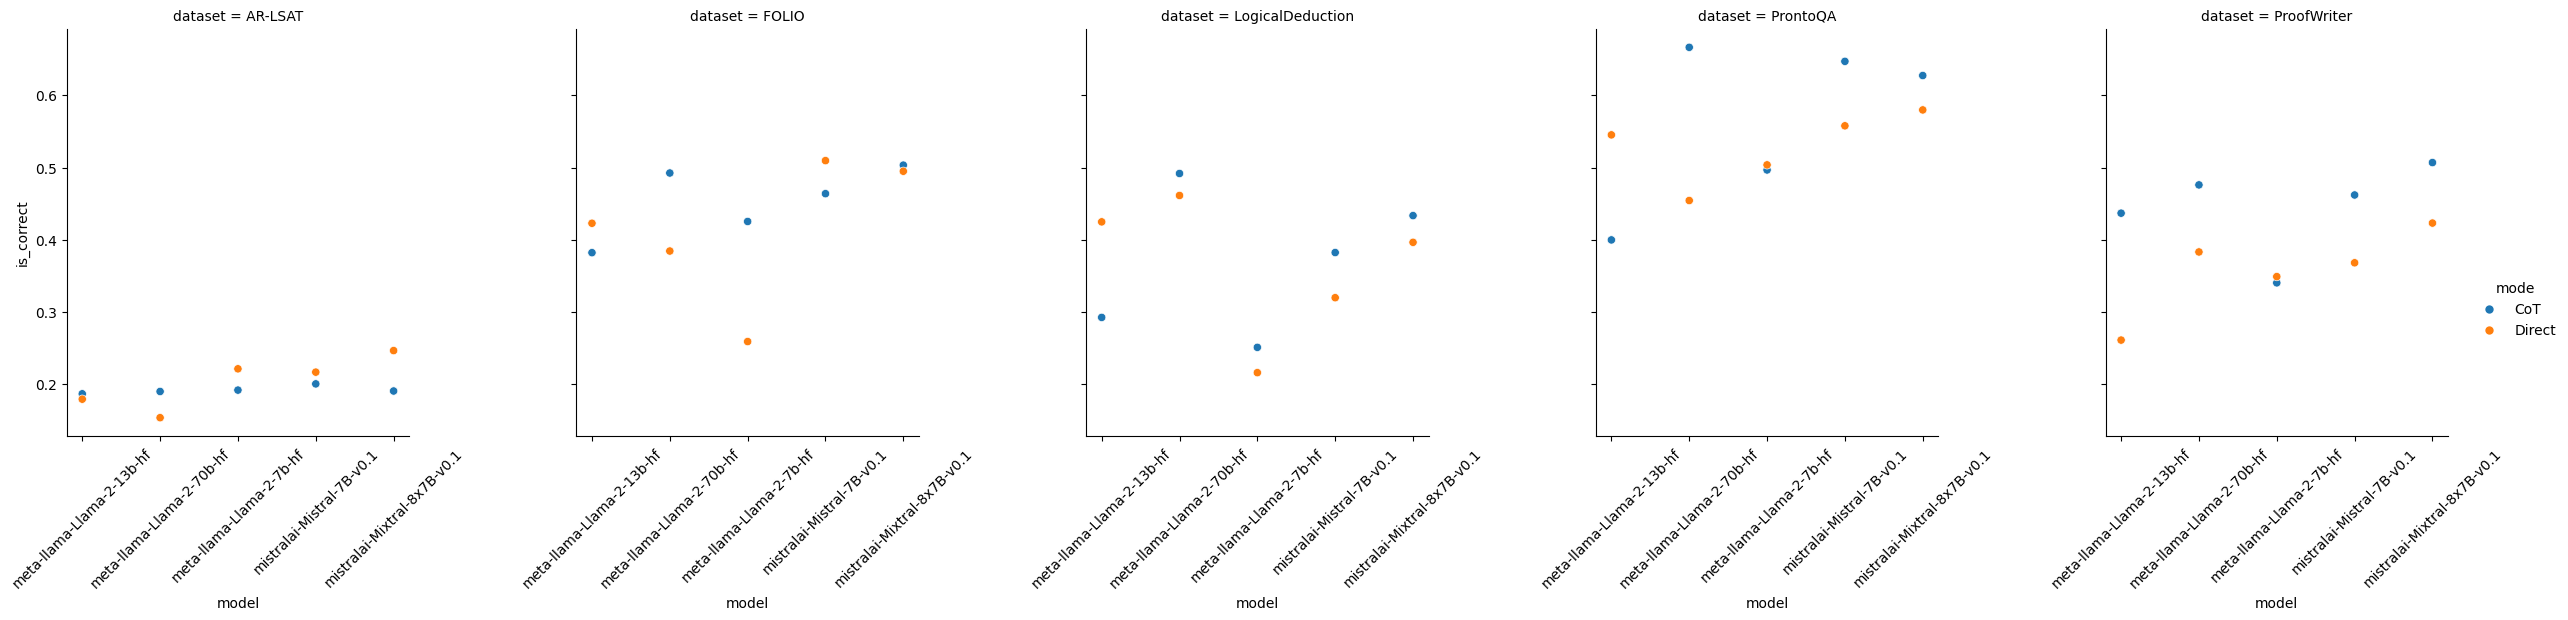

In [11]:
sns.relplot(data=df_all4,x="model",y="is_correct",col="dataset",hue="mode").tick_params(axis='x', rotation=45)

In [12]:
df_logic=[]
for file in os.listdir("./outputs/logic_inference"):
    if "mini_test" in file:
        continue

    if "minitest" in file:
        continue

    if "Bloke" in file:
        continue

    # if "backup-random" in file:
    #     continue

    if "checkpoint" in file:
        continue

    if 'self-refine' in file:
        refine, dataset, split, model, backup = file.split("_")
        refine = int(refine.split('-')[-1])
    else:
        dataset, split, model, backup = file.split("_")
        refine = 0
    
    result_file = os.path.join("./outputs/logic_inference",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()
    df=pd.DataFrame(all_samples)
    if len(df) == 0:
        print(file)
        continue
    df["clean_answer"] = df.predicted_answer.apply(get_choice)
    df = df.drop(columns=["question", "predicted_answer","context"])
    df["answer"] = df.answer.str.replace('(', '').replace(')', '')
    df["is_correct"] = df.answer == df.clean_answer
    df["is_empty"] = df.clean_answer == ''
    df["mode"] = 'Logic'
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model
    df["refiment"] = refine
    df_logic.append(df)

ProntoQA_train_meta-llama-Llama-2-7b-hf_backup-random.json
ProofWriter_dev_meta-llama-Llama-2-70b-hf-ProofWriter-sft-full-0-lora-r-16-zero-0-neftune-0-best-beam5-group1-zero-0_backup-random.json
ProofWriter_dev_meta-llama-Llama-2-70b-hf-ProofWriter-sft-full-0-lora-r-16-zero-0-neftune-0-best-zero-0_backup-random.json
ProntoQA_train_mistralai-Mistral-7B-v0.1_backup-random.json
ProntoQA_train_mistralai-Mixtral-8x7B-v0.1_backup-random.json
ProntoQA_train_meta-llama-Llama-2-13b-hf_backup-random.json
ProntoQA_train_meta-llama-Llama-2-70b-hf_backup-random.json


In [13]:
df_programs=[]
for file in os.listdir("./outputs/logic_programs"):
    if "mini_test" in file:
        continue

    if "minitest" in file:
        continue

    if "Bloke" in file:
        continue

    # if "backup-random" in file:
    #     continue

    if "checkpoint" in file:
        continue

    if 'self-refine' in file:
        refine, dataset, split, model = file.split("_")
        refine = int(refine.split('-')[-1])
    else:
        dataset, split, model = file.split("_")
        refine = 0
    
    result_file = os.path.join("./outputs/logic_programs",file)
    with open(result_file, 'r') as f:
        all_samples = json.load(f)
        f.close()

    df=pd.DataFrame(all_samples)
    if len(df) == 0:
        print(file)
        continue
    df["dataset"] = dataset
    df["split"] = split
    df["model"] = model[:-5]
    df["refiment"] = refine
    df_programs.append(df)

In [14]:
df_logic2=pd.concat(df_logic)

df_logic2["n_beam"]=df_logic2.groupby(["id","model","dataset","split","refiment"]).cumcount()

df_logic2 = df_logic2.loc[df_logic2["n_beam"] == 0]

df_total2 = pd.concat([df_all2,df_logic2])

df_total5 = df_total2.loc[(df_total2["mode"] == "Logic"),:]

fails = df_total5.loc[df_total5["flag"] != "success",:].groupby(["model","dataset","split","refiment"])[["flag"]].count()

total = df_total5.groupby(["model","dataset","split","refiment"])[["flag"]].count()

In [15]:
# df_total5.loc[(df_total5.dataset=="LogicalDeduction") & (df_total5.id=="logical_deduction_172"),:]

In [16]:
compilation_rate = (total-fails)/total

In [17]:
compilation_rate = compilation_rate.reset_index()

In [18]:
df_total6 = df_total5.loc[df_total5["flag"] == "success",:].groupby(["model","dataset","mode","split","refiment"])[["is_correct","is_empty"]].mean().reset_index()

In [19]:
df_total6

,model,dataset,mode,split,refiment,is_correct,is_empty
0,gpt-3.5-turbo,AR-LSAT,Logic,dev,0,0.318182,0.000000
1,gpt-3.5-turbo,FOLIO,Logic,dev,0,0.640000,0.000000
2,gpt-3.5-turbo,LogicalDeduction,Logic,dev,0,0.662116,0.201365
3,gpt-3.5-turbo,ProntoQA,Logic,dev,0,0.597802,0.000000
4,gpt-3.5-turbo,ProofWriter,Logic,dev,0,0.678571,0.000000
...,...,...,...,...,...,...,...
137,mistralai-Mixtral-8x7B-v0.1,LogicalDeduction,Logic,dev,2,0.291946,0.647651
138,mistralai-Mixtral-8x7B-v0.1,LogicalDeduction,Logic,dev,3,0.291946,0.647651
139,mistralai-Mixtral-8x7B-v0.1,LogicalDeduction,Logic,train,0,0.602168,0.278565
140,mistralai-Mixtral-8x7B-v0.1,ProntoQA,Logic,dev,0,0.666667,0.000000


In [20]:
results_summary = pd.merge(compilation_rate,df_total6, how="left")

In [21]:
results_summary.loc[results_summary.model=="gpt-4"]

,model,dataset,split,refiment,flag,mode,is_correct,is_empty
6,gpt-4,AR-LSAT,dev,0,0.326087,Logic,0.600000,0.000000
7,gpt-4,FOLIO,dev,0,0.789216,Logic,0.807453,0.000000
8,gpt-4,LogicalDeduction,dev,0,NaN,Logic,0.876254,0.050167
9,gpt-4,ProntoQA,dev,0,NaN,Logic,0.832000,0.000000
10,gpt-4,ProofWriter,dev,0,0.990000,Logic,0.796296,0.000000


In [22]:
results_summary.model.str.split('sft-best')

0        [HuggingFaceTB-SmolLM-135M]
1                    [gpt-3.5-turbo]
2                    [gpt-3.5-turbo]
3                    [gpt-3.5-turbo]
4                    [gpt-3.5-turbo]
                   ...              
186    [mistralai-Mixtral-8x7B-v0.1]
187    [mistralai-Mixtral-8x7B-v0.1]
188    [mistralai-Mixtral-8x7B-v0.1]
189    [mistralai-Mixtral-8x7B-v0.1]
190    [mistralai-Mixtral-8x7B-v0.1]
Name: model, Length: 191, dtype: object

In [23]:
def extract_base_model(model_name):
    datasets = ['AR-LSAT', 'ProntoQA', 'ProofWriter', 'FOLIO', 'LogicalDeduction']
    
    for dataset in datasets:
        if dataset in model_name:
            return model_name.split(dataset)[0].strip('-')
    
    return model_name  # Return original if no match found

# Apply the function to create a new column
results_summary['base_model'] = results_summary['model'].apply(extract_base_model)

In [24]:
import pandas as pd
import re

def extract_model_info(model_name):
    info = {}
    
    # Extract full value
    full_match = re.search(r'full-(\d+)', model_name)
    info['full'] = int(full_match.group(1)) if full_match else None
    
    # Extract lora-r value
    lora_r_match = re.search(r'lora-r-(\d+)', model_name)
    info['lora_r'] = int(lora_r_match.group(1)) if lora_r_match else None
    
    # Extract zero value
    zero_match = re.search(r'zero-(\d+)', model_name)
    info['zero'] = int(zero_match.group(1)) if zero_match else None
    
    # Extract neftune value
    neftune_match = re.search(r'neftune-(\d+)', model_name)
    info['neftune'] = int(neftune_match.group(1)) if neftune_match else 0
    
    # Extract beam value
    beam_match = re.search(r'beam(\d+)', model_name)
    info['beam'] = int(beam_match.group(1)) if beam_match else 1
    
    # Extract group value
    group_match = re.search(r'group(\d+)', model_name)
    info['group'] = int(group_match.group(1)) if group_match else 0
    
    # Extract last zero value
    last_zero_match = re.search(r'zero-(\d+)$', model_name)
    info['last_zero'] = int(last_zero_match.group(1)) if last_zero_match else None
    
    return pd.Series(info)

# Create a sample DataFrame
data = {
    'model_name': [
        'meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-16-zero-1-neftune-0-best-beam5-group1-zero-0',
        'meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-1-lora-r-8-zero-2-neftune-1-best-beam3-group2-zero-1',
        'meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-32-zero-0-neftune-0-best-beam7-group3-zero-2'
    ]
}

df = pd.DataFrame(data)

# Apply the function to the 'model_name' column and create new columns
df = pd.concat([df, df['model_name'].apply(extract_model_info)], axis=1)

# Display the result
print(df)

                                          model_name  full  lora_r  zero  \
0  meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...     0      16     1   
1  meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...     1       8     2   
2  meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...     0      32     0   

   neftune  beam  group  last_zero  
0        0     5      1          0  
1        1     3      2          1  
2        0     7      3          2  


In [25]:
results_summary = pd.concat([results_summary, results_summary['model'].apply(extract_model_info)], axis=1)

In [26]:
results_summary

,model,dataset,split,refiment,flag,mode,is_correct,is_empty,base_model,full,lora_r,zero,neftune,beam,group,last_zero
0,HuggingFaceTB-SmolLM-135M,AR-LSAT,dev,0,0.000000,NaN,NaN,NaN,HuggingFaceTB-SmolLM-135M,NaN,NaN,NaN,0.0,1.0,0.0,NaN
1,gpt-3.5-turbo,AR-LSAT,dev,0,0.190476,Logic,0.318182,0.000000,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
2,gpt-3.5-turbo,FOLIO,dev,0,0.612745,Logic,0.640000,0.000000,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
3,gpt-3.5-turbo,LogicalDeduction,dev,0,0.976667,Logic,0.662116,0.201365,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
4,gpt-3.5-turbo,ProntoQA,dev,0,0.910000,Logic,0.597802,0.000000,gpt-3.5-turbo,NaN,NaN,NaN,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,mistralai-Mixtral-8x7B-v0.1,ProofWriter,dev,0,0.000000,NaN,NaN,NaN,mistralai-Mixtral-8x7B-v0.1,NaN,NaN,NaN,0.0,1.0,0.0,NaN
187,mistralai-Mixtral-8x7B-v0.1,ProofWriter,dev,1,0.000000,NaN,NaN,NaN,mistralai-Mixtral-8x7B-v0.1,NaN,NaN,NaN,0.0,1.0,0.0,NaN
188,mistralai-Mixtral-8x7B-v0.1,ProofWriter,dev,2,0.000000,NaN,NaN,NaN,mistralai-Mixtral-8x7B-v0.1,NaN,NaN,NaN,0.0,1.0,0.0,NaN
189,mistralai-Mixtral-8x7B-v0.1,ProofWriter,dev,3,0.000000,NaN,NaN,NaN,mistralai-Mixtral-8x7B-v0.1,NaN,NaN,NaN,0.0,1.0,0.0,NaN


In [27]:
results_summary['is_tuned'] = results_summary['model'].str.contains('sft')

In [28]:
results_summary = results_summary.rename(columns={"flag":"compilation_rate"})

In [29]:
results_summary["is_correct"] = results_summary.is_correct.fillna(0)
results_summary["is_empty"] = results_summary.is_empty.fillna(0)
results_summary["compilation_rate"] = results_summary.compilation_rate.fillna(1)
results_summary["mode"] = results_summary["mode"].fillna("Logic")

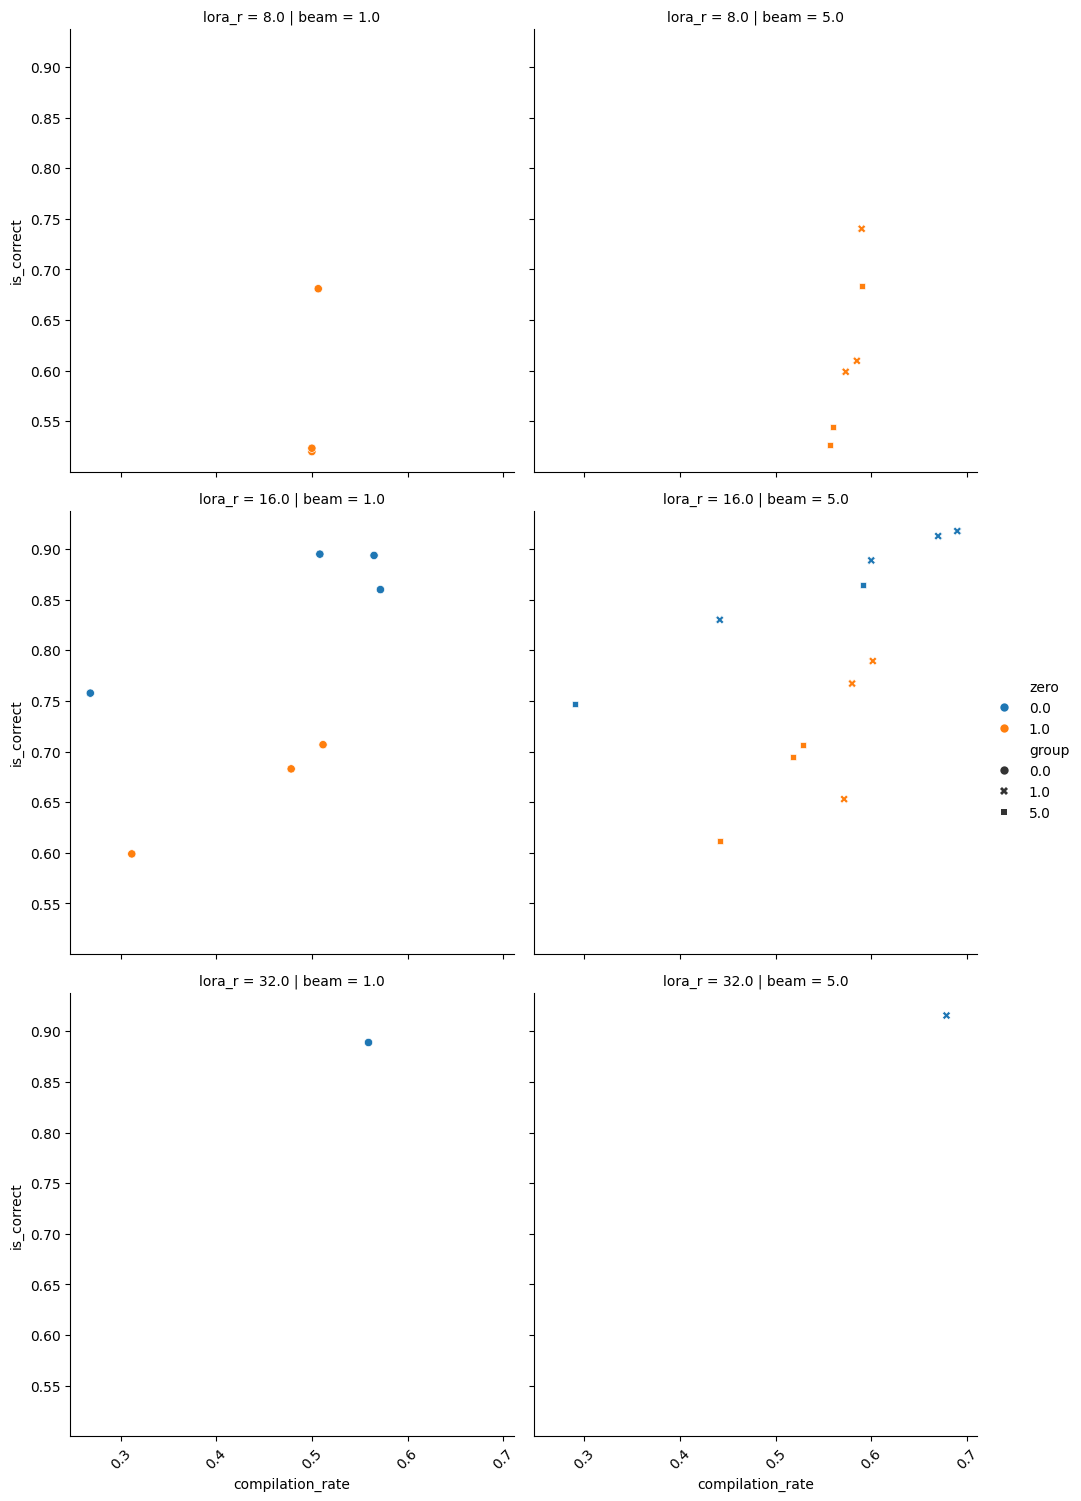

In [32]:
sns.relplot(data=results_summary.loc[(results_filtered.last_zero==0) & (results_summary.dataset=="ProofWriter") & (results_summary.split=="dev") & (results_summary.is_tuned==True)],x="compilation_rate",y="is_correct",col="beam",row="lora_r",hue="zero",style="group").tick_params(axis='x', rotation=45)

In [31]:
results_filtered = results_summary.loc[(results_summary.dataset=="ProofWriter") & (results_summary.split=="dev") & (results_summary.is_tuned==True)]

In [32]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_
reg.intercept_
reg.predict(np.array([[3, 5]]))

array([16.])

In [33]:
results_filtered

,model,dataset,split,refiment,compilation_rate,mode,is_correct,is_empty,base_model,full,lora_r,zero,neftune,beam,group,last_zero,is_tuned
82,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.600000,Logic,0.888889,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,0.0,5.0,5.0,1.0,0.0,True
83,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.076667,Logic,0.673913,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,0.0,5.0,5.0,1.0,1.0,True
84,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.591667,Logic,0.864789,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,0.0,5.0,5.0,5.0,0.0,True
85,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.026667,Logic,0.625000,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,0.0,5.0,5.0,5.0,1.0,True
86,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.571667,Logic,0.860058,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,0.0,5.0,1.0,0.0,0.0,True
87,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.008333,Logic,0.600000,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,0.0,5.0,1.0,0.0,1.0,True
88,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.601667,Logic,0.789474,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,1.0,0.0,5.0,1.0,0.0,True
89,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.006667,Logic,1.000000,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,1.0,0.0,5.0,1.0,1.0,True
90,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.528333,Logic,0.706625,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,1.0,0.0,5.0,5.0,0.0,True
91,meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-...,ProofWriter,dev,0,0.061667,Logic,0.864865,0.0,meta-llama-Llama-2-7b-hf,0.0,16.0,1.0,0.0,5.0,5.0,1.0,True


In [42]:
results_filtered2 = results_filtered.loc[:,results_filtered.nunique()!=1].drop(columns="model")

In [43]:
X = results_filtered2.loc[results_filtered2.last_zero==0,:].drop(columns=["compilation_rate","is_correct"])

In [44]:
y = results_filtered2.loc[results_filtered2.last_zero==0,:]["is_correct"]

In [45]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_

array([-0.11665785,  0.00601227, -0.1495667 ,  0.00274373,  0.02097466,
       -0.01555911,  0.        ])

In [46]:
reg.score(X, y)

0.9814030797837626

In [47]:
reg.coef_>0

array([False,  True, False,  True,  True, False, False])

In [48]:
pd.Series(reg.coef_>0, index=X.columns)

full         False
lora_r        True
zero         False
neftune       True
beam          True
group        False
last_zero    False
dtype: bool

In [70]:
X

,full,lora_r,zero,neftune,beam,group,last_zero
82,0.0,16.0,1.0,0.0,5.0,1.0,0.0
84,0.0,16.0,1.0,0.0,5.0,5.0,0.0
86,0.0,16.0,1.0,0.0,1.0,0.0,0.0
88,0.0,16.0,1.0,5.0,5.0,1.0,0.0
90,0.0,16.0,1.0,5.0,5.0,5.0,0.0
92,0.0,16.0,1.0,5.0,1.0,0.0,0.0
94,0.0,8.0,1.0,5.0,5.0,1.0,0.0
96,0.0,8.0,1.0,5.0,5.0,5.0,0.0
97,0.0,8.0,1.0,5.0,5.0,5.0,1.0
98,0.0,8.0,1.0,5.0,1.0,0.0,0.0


In [113]:
df_total5

,id,answer,flag,clean_answer,is_correct,is_empty,mode,dataset,split,model,refiment,program,error_message,n_beam,is_correct_compile
0,logical_deduction_0,D,success,,False,True,Logic,LogicalDeduction,dev,mistralai-Mixtral-8x7B-v0.1,0,NaN,NaN,0.0,False
1,logical_deduction_1,A,success,,False,True,Logic,LogicalDeduction,dev,mistralai-Mixtral-8x7B-v0.1,0,NaN,NaN,0.0,False
2,logical_deduction_2,E,success,,False,True,Logic,LogicalDeduction,dev,mistralai-Mixtral-8x7B-v0.1,0,NaN,NaN,0.0,False
3,logical_deduction_3,A,success,A,True,False,Logic,LogicalDeduction,dev,mistralai-Mixtral-8x7B-v0.1,0,NaN,NaN,0.0,True
4,logical_deduction_4,E,success,E,True,False,Logic,LogicalDeduction,dev,mistralai-Mixtral-8x7B-v0.1,0,NaN,NaN,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ProntoQA_496,B,execution error,B,True,False,Logic,ProntoQA,dev,mistralai-Mistral-7B-v0.1,0,NaN,NaN,0.0,False
496,ProntoQA_497,B,execution error,B,True,False,Logic,ProntoQA,dev,mistralai-Mistral-7B-v0.1,0,NaN,NaN,0.0,False
497,ProntoQA_498,B,parsing error,B,True,False,Logic,ProntoQA,dev,mistralai-Mistral-7B-v0.1,0,NaN,NaN,0.0,False
498,ProntoQA_499,B,execution error,B,True,False,Logic,ProntoQA,dev,mistralai-Mistral-7B-v0.1,0,NaN,NaN,0.0,False


In [108]:
df_total5.loc[:,"is_correct_compile"]=(df_total5["flag"]=="success") & (df_total5["is_correct"])

In [109]:
df_total5_pivot = df_total5.loc[(df_total5.dataset=="ProofWriter") & (df_total5.split=="dev")].pivot_table('is_correct_compile', ['id'], 'model')

In [110]:
df_total5_pivot = df_total5_pivot.drop(columns=['gpt-3.5-turbo','gpt-4'])

<Axes: >

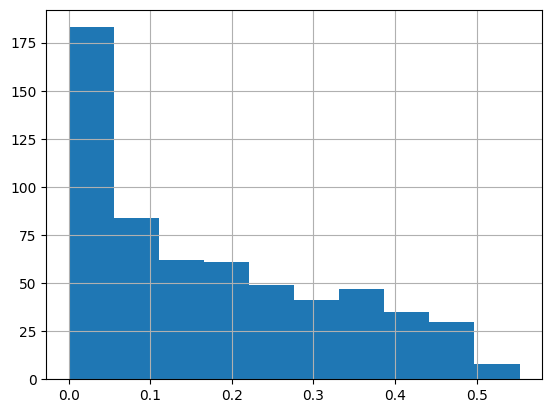

In [111]:
df_total5_pivot.mean(axis=1).hist()

In [112]:
df_total5_pivot.corr().abs().mean()

model
meta-llama-Llama-2-13b-hf                                                                                   NaN
meta-llama-Llama-2-70b-hf                                                                                   NaN
meta-llama-Llama-2-7b-hf                                                                                    NaN
meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-16-zero-1-neftune-0-best-beam5-group1-zero-0    0.281017
meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-16-zero-1-neftune-0-best-beam5-group1-zero-1    0.097014
meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-16-zero-1-neftune-0-best-beam5-group5-zero-0    0.325468
meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-16-zero-1-neftune-0-best-beam5-group5-zero-1    0.083280
meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-16-zero-1-neftune-0-best-zero-0                 0.326266
meta-llama-Llama-2-7b-hf-ProofWriter-sft-full-0-lora-r-16-zero-1-neftune-0-best-zero-1            

In [114]:
df_total5_pivot.max(axis=1).mean()

0.88

In [122]:
df_total5_pivot_corr = df_total5_pivot.corr().dropna(how="all").dropna(how="all",axis=1)

<Axes: xlabel='model', ylabel='model'>

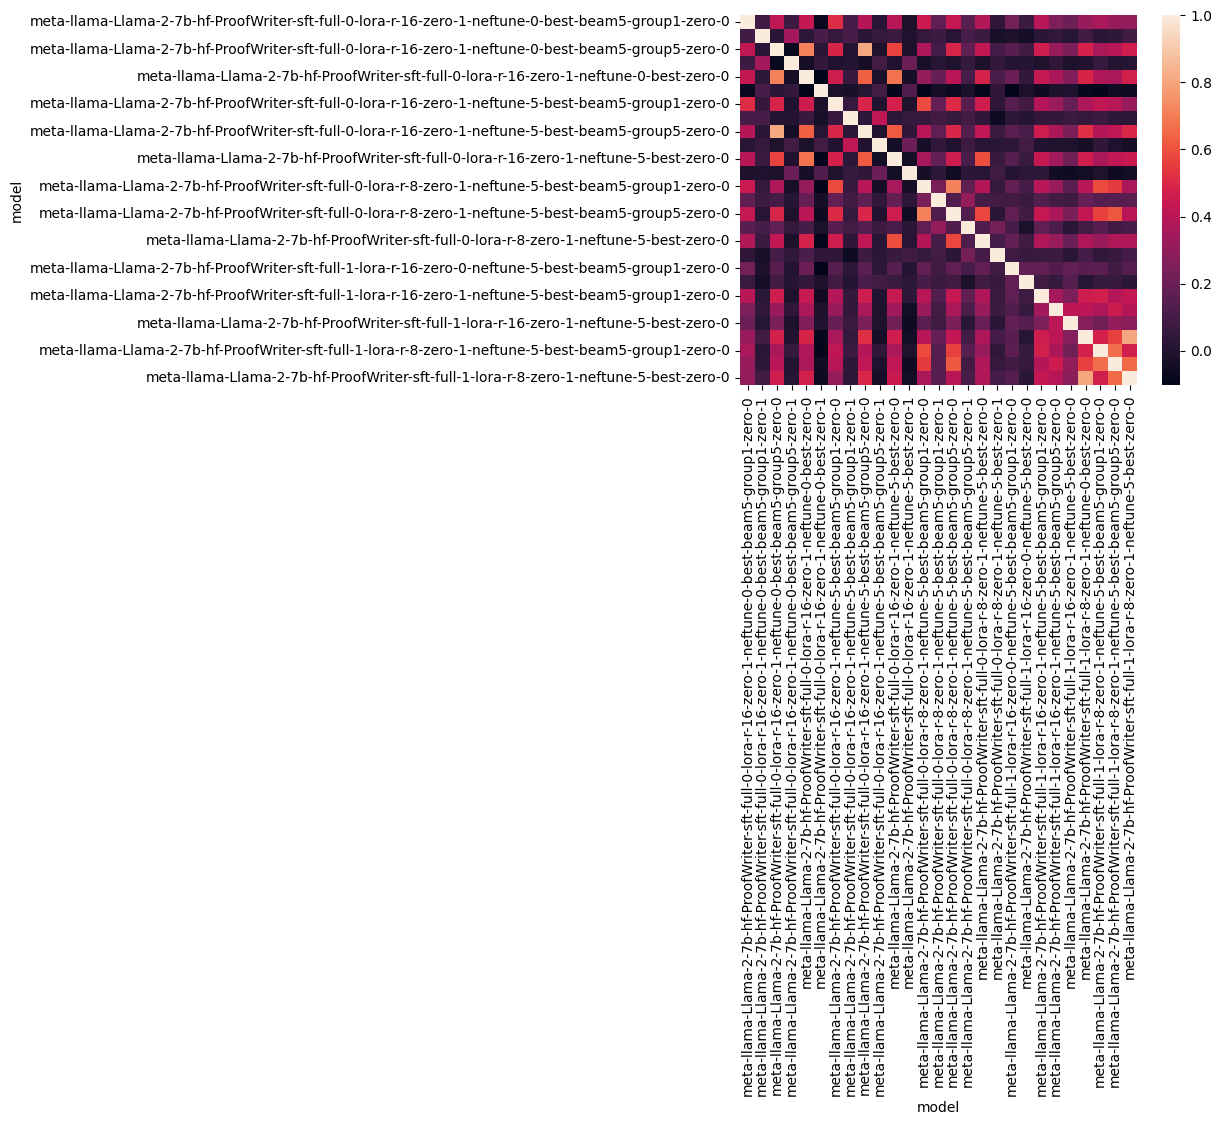

In [124]:
sns.heatmap(df_total5_pivot_corr, annot=False)

In [34]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


In [35]:
path="/mnt/evafs/groups/luckner-lab/models/mistralai/Mistral-7B-v0.1/LogicalDeduction/sft/runs/Jun11_22-53-05_dgx-4.eden" #folderpath
df=tflog2pandas(path)

In [36]:
df.metric.unique()

array(['train/loss', 'train/grad_norm', 'train/learning_rate',
       'train/epoch', 'eval/loss', 'eval/runtime',
       'eval/samples_per_second', 'eval/steps_per_second',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second', 'train/total_flos',
       'train/train_loss'], dtype=object)

In [37]:
df

,metric,value,step
0,train/loss,3.482000e-01,10.0
1,train/loss,9.910000e-02,20.0
2,train/loss,5.540000e-02,30.0
3,train/loss,4.700000e-02,40.0
4,train/loss,4.270000e-02,50.0
...,...,...,...
0,train/train_runtime,7.297424e+02,396.0
0,train/train_samples_per_second,2.168000e+00,396.0
0,train/train_steps_per_second,5.430000e-01,396.0
0,train/total_flos,1.106620e+17,396.0


In [38]:
# sns.lineplot(data=df.loc[df.metric=="eval/loss",:],x="step",y="value").set(ylabel="Train Loss", title="LogicalDeduction")

[Text(0, 0.5, 'Train Loss'), Text(0.5, 1.0, 'LogicalDeduction')]

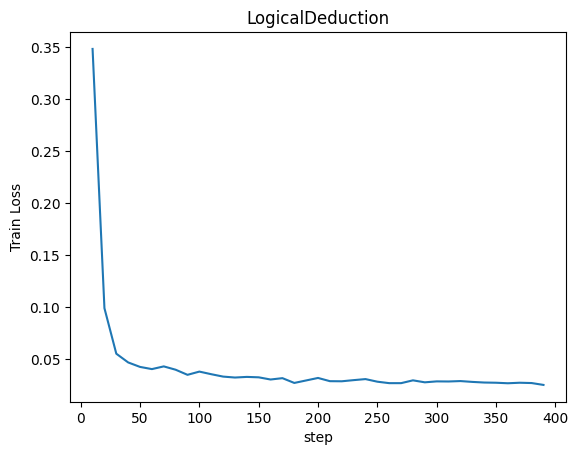

In [39]:
sns.lineplot(data=df.loc[df.metric=="train/loss",:],x="step",y="value").set(ylabel="Train Loss", title="LogicalDeduction")

In [38]:
# sns.relplot(data=df,x="step",y="value",row="metric",kind="line")

In [39]:
df.loc[df.metric=="ppo/policy/ratio",:]

,metric,value,step


<Axes: xlabel='step', ylabel='value'>

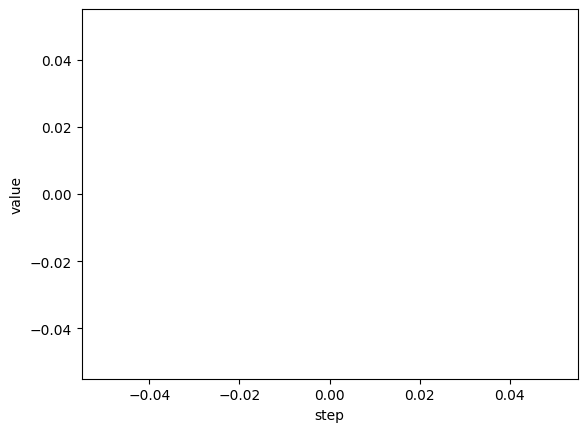

In [40]:
sns.lineplot(data=df.loc[df.metric=="objective/kl",:],x="step",y="value")

In [41]:
bool(0)

False

<Axes: xlabel='step', ylabel='value'>

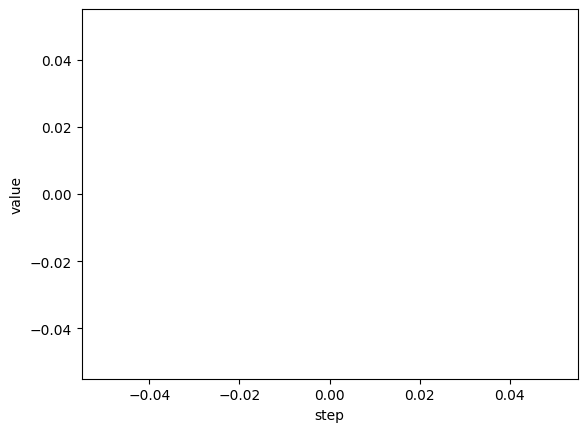

In [42]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/approxkl",:],x="step",y="value")

<Axes: xlabel='step', ylabel='value'>

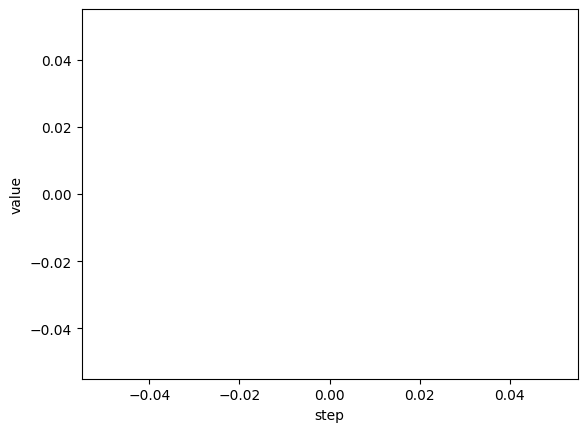

In [43]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/loss",:],x="step",y="value")

<Axes: xlabel='step', ylabel='value'>

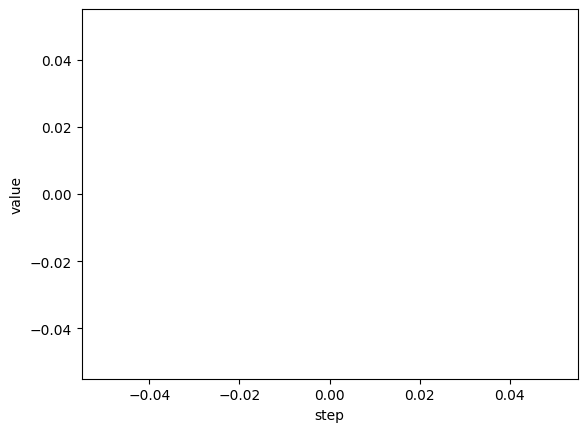

In [44]:
sns.lineplot(data=df.loc[df.metric=="ppo/policy/approxkl",:],x="step",y="value")

In [45]:
df.loc[df.metric=="env/reward_mean",:]

,metric,value,step


<Axes: xlabel='step', ylabel='value'>

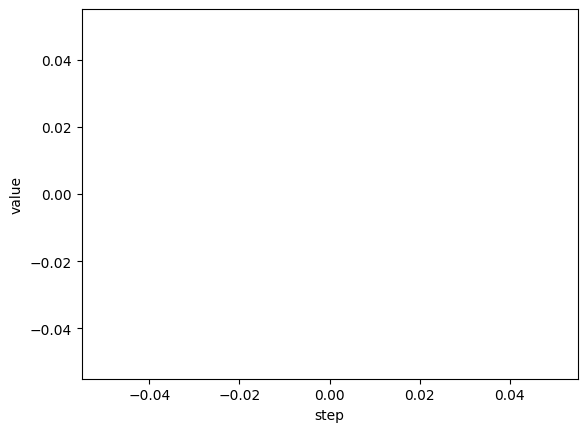

In [46]:
sns.lineplot(data=df.loc[df.metric=="env/reward_mean",:],x="step",y="value")